In [76]:
%%capture
# Add packages installation code

# source - https://www.kaggle.com/code/bunny11/store-sales-forecasting-by-gurpreetsingh
#https://www.kaggle.com/code/csmohamedayman/store-sales-time-series-forecasting#Baseline-Model

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, \
                                    median_absolute_error, max_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import time

import warnings
warnings.filterwarnings('ignore')

In [78]:
train_data = pd.read_csv("./store-sales-time-series-forecasting/train.csv")
test_data = pd.read_csv("./store-sales-time-series-forecasting/test.csv")
holidays = pd.read_csv("./store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("./store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("./store-sales-time-series-forecasting/transactions.csv")

In [79]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [80]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [81]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [82]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [83]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [84]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [85]:
print(f"Date range of the train data are from - {train_data.loc[:,'date'][0]} to {train_data.loc[:,'date'][len(train_data) - 1]}")

Date range of the train data are from - 2013-01-01 to 2017-08-15


In [86]:
train_data.drop(columns = ['id'], inplace=True)

In [87]:
# train_data['date'] = pd.to_datetime(train_data['date'], format = "%Y-%m-%d")

### EDA - Data Preprocessing

In [88]:
print(f'train_data.shape   : {train_data.shape}')
print(f'test_data.shape    : {test_data.shape}')
print(f'oil.shape          : {oil.shape}')
print(f'holidays.shape     : {holidays.shape}')
print(f'stores.shape       : {stores.shape}')
print(f'transactions.shape : {transactions.shape}')

train_data.shape   : (3000888, 5)
test_data.shape    : (28512, 5)
oil.shape          : (1218, 2)
holidays.shape     : (350, 6)
stores.shape       : (54, 5)
transactions.shape : (83488, 3)


In [89]:
train_data = train_data.merge(oil, on = "date", how = "left")
train_data = train_data.merge(holidays, on = "date", how = "left")
train_data = train_data.merge(stores, on = "store_nbr", how = "left")
train_data = train_data.merge(transactions, on = ["date", "store_nbr"], how = "left")

In [90]:
test_data = test_data.merge(oil, on = "date", how = "left")
test_data = test_data.merge(holidays, on = "date", how = "left")
test_data = test_data.merge(stores, on = "store_nbr", how = "left")
test_data = test_data.merge(transactions, on = ["date", "store_nbr"], how = "left")

In [91]:
target_feat = list(set(train_data.columns)-set(test_data.columns))[0]

In [92]:
def df_dtypes(df):
    df_dtypes = df.columns.groupby(df.dtypes)
    df_dtypes = pd.DataFrame({
        'dtype':     list(df_dtypes.keys()),
        'Number of columns': [len(df_dtypes[key])  for key in df_dtypes.keys()],
        'columns':   [list(df_dtypes[key]) for key in df_dtypes.keys()],
    })
    df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])

    return df_dtypes

In [93]:
df_dtypes(train_data)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,3,"['sales', 'dcoilwtico', 'transactions']"
2,object,10,"['date', 'family', 'type_x', 'locale', 'locale_name', 'description', 'transferred', 'city', 'state', 'type_y']"


In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 16 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   dcoilwtico    float64
 6   type_x        object 
 7   locale        object 
 8   locale_name   object 
 9   description   object 
 10  transferred   object 
 11  city          object 
 12  state         object 
 13  type_y        object 
 14  cluster       int64  
 15  transactions  float64
dtypes: float64(3), int64(3), object(10)
memory usage: 372.8+ MB


In [95]:
# building custom data info table using custom defined functions
def get_dtype(df):
    return [df[col].dtype for col in df.columns]

def get_count(df):
    return [df[col].count() for col in df.columns]

def get_mean(df, feat):
    return [round(df[col].mean(), 1) if col in feat else "" for col in df.columns]

def get_std(df, feat):
    return [round(df[col].std(), 1) if col in feat else "" for col in df.columns]

def get_min(df, feat):
    return [round(df[col].min(), 1) if col in feat else "" for col in df.columns]

def get_max(df, feat):
    return [round(df[col].max(), 1) if col in feat else "" for col in df.columns]

def get_quantile(df, feat, perc):
    return [round(df[col].quantile(perc), 1) if col in feat else "" for col in df.columns]

def get_IQR(df, feat):
    return [round(df[col].max() - df[col].min(), 1) if col in feat else "" for col in df.columns]

def get_nunique(df):
    return [df[col].nunique() for col in df.columns]

def get_unique(df, threshold):
    return [df[col].unique()  if df[col].nunique() < threshold else '' for col in df.columns]

def get_mode(df):
    return [df[col].mode()[0] if len(df[col].mode()) else "" for col in df.columns]

def get_mode_count(df):
    return [df[col].value_counts().max() for col in df.columns]

def get_mode_percentage(df):
    return [round(df[col].value_counts().max() * 100 / df.shape[0], 1) for col in df.columns]

def get_null_count(df):
    return [df[col].isnull().sum() for col in df.columns]

def get_null_percentage(df):
    return [round(df[col].isnull().mean() * 100, 1) for col in df.columns]

In [96]:
def build_my_info_table(df, nunique_threshold=35):
    numerical_features = df.select_dtypes(include=[np.number])
    df_info = pd.DataFrame({
        'column':   df.columns,
        'dtype':    get_dtype(df),
        'count':    get_count(df),
        'mean':     get_mean(df, numerical_features),
        'std':      get_std(df, numerical_features),
        'min':      get_min(df, numerical_features),
        '25%':      get_quantile(df, numerical_features, .25),
        '50%':      get_quantile(df, numerical_features, .5),
        '75%':      get_quantile(df, numerical_features, .75),
        'max':      get_max(df, numerical_features),
        'IQR':      get_IQR(df, numerical_features),
        'nunique':  get_nunique(df),
        'unique':   get_unique(df, nunique_threshold),
        'mode':     get_mode(df),
        'mode #':   get_mode_count(df),
        'mode %':   get_mode_percentage(df),
        'null #':   get_null_count(df),
        'null %':   get_null_percentage(df),
    })
    df_info = df_info.sort_values(by='dtype')
    return df_info

In [97]:
build_my_info_table(train_data)

,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
1,store_nbr,int64,3054348,27.5,15.6,1,14.0,27.5,41.0,54,53,54,,1,56562,1.9,0,0.0
4,onpromotion,int64,3054348,2.6,12.3,0,0.0,0.0,0.0,741,741,362,,0,2428528,79.5,0,0.0
14,cluster,int64,3054348,8.5,4.6,1,4.0,8.5,13.0,17,16,17,"[13, 15, 6, 7, 3, 12, 16, 9, 1, 10, 8, 2, 4, 5...",3,395934,13.0,0,0.0
3,sales,float64,3054348,359.0,1107.3,0.0,0.0,11.0,196.0,124717.0,124717.0,379610,,0.0,953741,31.2,0,0.0
5,dcoilwtico,float64,2099196,68.0,25.7,26.2,46.4,53.4,95.8,110.6,84.4,994,,46.02,7128,0.2,955152,31.3
15,transactions,float64,2805231,1697.1,966.8,5.0,1046.0,1395.0,2081.0,8359.0,8354.0,4993,,1207.0,2970,0.1,249117,8.2
0,date,object,3054348,,,,,,,,,1684,,2014-06-25,7128,0.2,0,0.0
2,family,object,3054348,,,,,,,,,33,"[AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...",AUTOMOTIVE,92556,3.0,0,0.0
6,type_x,object,502524,,,,,,,,,6,"[Holiday, nan, Work Day, Additional, Event, Tr...",Holiday,304722,10.0,2551824,83.5
7,locale,object,502524,,,,,,,,,3,"[National, nan, Local, Regional]",National,261954,8.6,2551824,83.5


In [98]:
def plot_bar_chart(df, x, y, xlabel, ylabel, title, xmin=None, xmax=None, palette="muted"):
    if df.shape[0] == 0:
        return
    size = (12, df.shape[0] / 4 + 1)
    plt.figure(figsize=size)
    sns.barplot(y=df[y], x=df[x], palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not xmin and not xmax:
        xmin, xmax = df[x].min(), df[x].max()
        xrange = (xmax - xmin) * .1
        xmin, xmax = xmin-xrange, xmax+xrange
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()

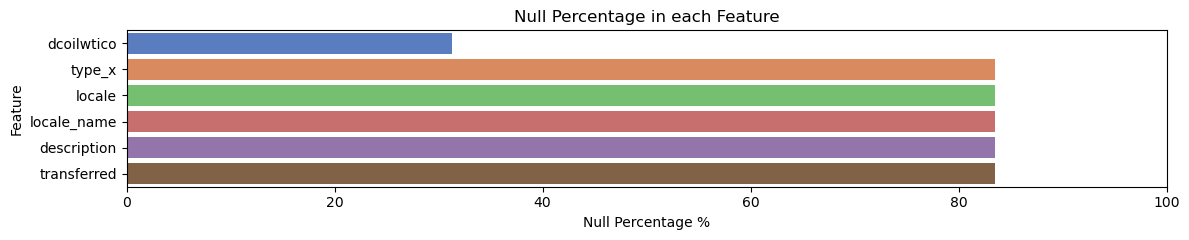

In [99]:
train_info = build_my_info_table(train_data)
nan_df = train_info[train_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature', xmin=0, xmax=100)

In [100]:
train_data = train_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))
test_data = test_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))

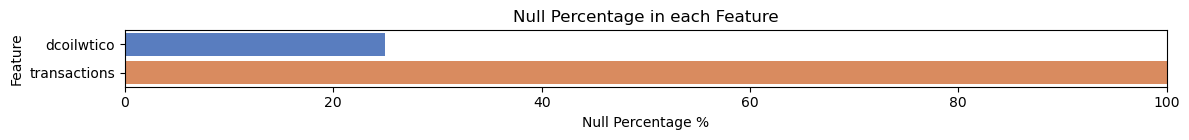

In [101]:
test_info = build_my_info_table(test_data)
nan_df = test_info[test_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature',
               title='Null Percentage in each Feature', xmin=0, xmax=100)

In [102]:
train_data = train_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))
test_data = test_data.drop(columns = list(nan_df[nan_df['null %'] > 50]['column']))

In [103]:
# replacing other na and inf values in the columns
def fill_na(df):
    num_feat = df.select_dtypes(include=[np.number]).columns
    cat_feat = df.select_dtypes(exclude=[np.number]).columns
    
    df[num_feat] = df[num_feat].fillna(df[num_feat].median())
    
    for col in cat_feat:
        df[col] = df[col].fillna(df[col].mode()[0])
    
def replace_inf(df):
    num_feat = df.select_dtypes(include=[np.number]).columns
    df[num_feat] = df[num_feat].replace([np.inf, -np.inf], np.nan)
    df[num_feat] = df[num_feat].fillna(df[num_feat].median())

In [104]:
replace_inf(train_data)
replace_inf(test_data)

fill_na(train_data)
fill_na(test_data)

In [105]:
# getting categorical and numerical features
def get_num(df, nunique_th=35):
    num_feat = df.select_dtypes(include=[np.number]).columns
    
    numerical_feat = [col for col in num_feat if df[col].nunique() >= nunique_th]
    
    return numerical_feat

def get_cat(df, nunique_th=35):
    cat_feat = [col for col in df.columns if df[col].nunique() < nunique_th]
    
    return cat_feat

In [106]:
categorical_features = get_cat(train_data)
numerical_features = get_num(train_data)

print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['family', 'city', 'state', 'type_y', 'cluster']
Numerical Features: ['store_nbr', 'sales', 'onpromotion', 'dcoilwtico']


In [107]:
# different plots
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

def my_distplot(df, col, ax):
    sns.distplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

def my_kdeplot(df, col, ax):
    sns.kdeplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Histogram plot for the columns {ax}")

In [108]:
# categorical plots
def my_pie_chart(df, col):
    pass

# complete visualizations later

### Modeling

In [109]:
df_dtypes(train_data)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,2,"['sales', 'dcoilwtico']"
2,object,5,"['date', 'family', 'city', 'state', 'type_y']"


In [110]:
train_model = train_data.copy()
test_model  = test_data.copy()

In [111]:
def remove_col(df, col = "id"):
    if col not in df.columns:
        return df, None
    
    df_col = df[col]
    df = df.drop(columns=[col])
    
    return df, df_col

In [112]:
train_model, _ = remove_col(train_model)
test_model, _ = remove_col(test_model)

In [115]:
def encode_str_features(df):
    categorical_features = get_cat(df.select_dtypes(exclude=[np.number]))
    encoder = OrdinalEncoder()
    for col in categorical_features:
        df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1))

In [116]:
encode_str_features(train_model)
encode_str_features(test_model)
df_dtypes(train_model)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"
2,object,1,['date']


In [117]:
deleted_columns = list(train_model.select_dtypes(exclude=[np.number]).columns) + list(test_model.select_dtypes(exclude=[np.number]).columns)

deleted_columns = list(set(deleted_columns))

train_model = train_model.drop(columns=deleted_columns)
test_model  = test_model.drop(columns=deleted_columns)
df_dtypes(train_model)

,dtype,Number of columns,columns
0,int64,3,"['store_nbr', 'onpromotion', 'cluster']"
1,float64,6,"['family', 'sales', 'dcoilwtico', 'city', 'state', 'type_y']"


In [118]:
def get_evaluation_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    meae = median_absolute_error(y_test, y_pred)
    me = max_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    
    return {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Mean Absolute Percentage Error': mape,
        'Median Absolute Error': meae,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': evs,
    }

In [119]:
baseline_models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
#     'RandomForestRegressor':     RandomForestRegressor(),
#     'KNeighborsRegressor':       KNeighborsRegressor(),
}

In [120]:
def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = get_evaluation_metrics(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
        
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [121]:
def split_data_train_test(df, target_feature, test_size=0.2):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [122]:
X_train, X_test, y_train, y_test = split_data_train_test(train_model, target_feat)

In [ ]:
models_result = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.01 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...


In [ ]:
models_result

In [ ]:
# no feature engineering is done!